In [1]:
import numpy as np
import pandas as pd
import gzip, pickle, sys
import torch
import matplotlib.pyplot as plt
import os

In [2]:
# Data Preprocessing
f = gzip.open('mnist.pkl.gz', 'rb')
(input_train, output_train), (input_test, output_test), _ = pickle.load(f, encoding='bytes')
image_size = 28 # width and length

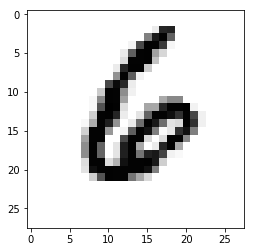

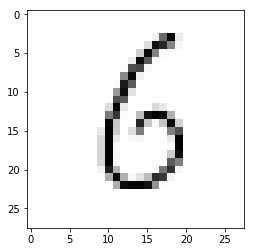

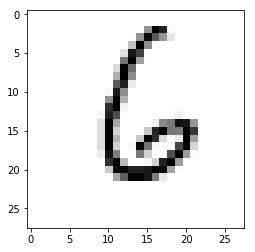

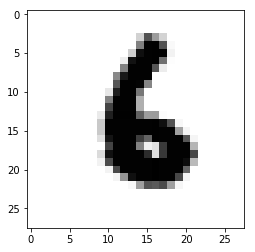

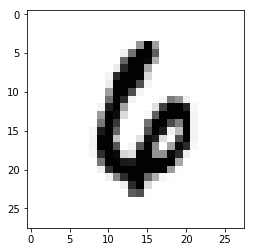

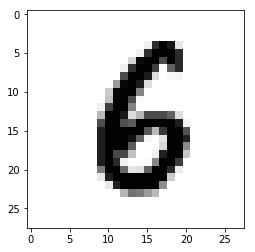

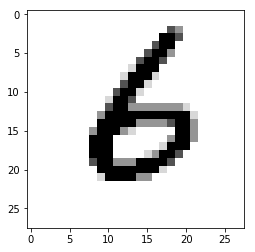

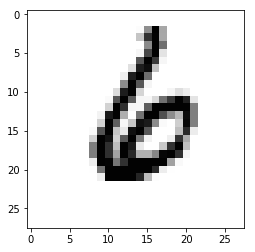

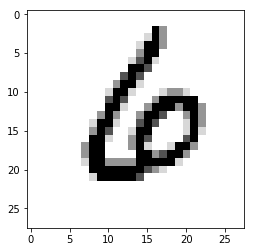

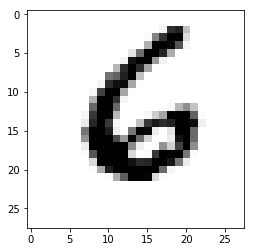

In [3]:
input_train = input_train[output_train == 5]
for i in range(10):
    img = input_train[i].reshape(28, 28)
    plt.imshow(img, cmap="Greys")
    plt.show()


In [4]:
input_train.shape

(4951, 784)

In [5]:
# make Data Suitable for RBM
bit_nu = 5
d = np.array(input_train) * (2 ** bit_nu)
d = np.array(d, dtype = int)
training_set = []
for i in range(len(d)):
    for j in range(len(d[i,:])):
        training_set.append([int(x) for x in np.binary_repr(d[i,j], width = bit_nu)])

training_set = np.array(training_set)
training_set = training_set.reshape((len(input_train), bit_nu * len(input_train[0])))
training_set = torch.FloatTensor(training_set)


In [10]:
# create my RBM class model
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.b = torch.randn(nv, 1)
        self.c = torch.randn(nh, 1)
        self.batch_size = 1
        self.rate = 1
        self.k = 1
    def sample_h(self, x):
        # x is in form of t * nv
        activation = torch.mm(self.W, x.t()) + self.c
        # p_h_given_v is in form of nh * t, so we transposed it
        p_h_given_v = torch.transpose(torch.sigmoid(activation), 0, 1)        
        return p_h_given_v, torch.bernoulli(p_h_given_v) 
    def sample_v(self, y):
        # y is in form of t * nh
        activation = torch.mm(torch.transpose(self.W, 0, 1), torch.transpose(y, 0, 1)) + self.b 
        # p_v_given_h is in form of nv * t, so we transposed it
        p_v_given_h = torch.transpose(torch.sigmoid(activation), 0, 1)        
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        # v0, vk is in form of t * nv
        # ph0, phk is in form of t * nh
        self.W += self.rate * (torch.mm(ph0.t(), v0) - torch.mm(phk.t(), vk)) / self.batch_size
        self.b += torch.reshape((self.rate * (torch.sum((v0 - vk).t(), dim = 1)) / self.batch_size), self.b.size())
        self.c += torch.reshape(self.rate * (torch.sum((ph0 - phk).t(), dim = 1)) / self.batch_size, self.c.size())
    def compile(self, rate = 1, k = 2):
        self.rate = rate
        self.k = k
    def loss(self, x):
        # v0 is in form of t * nv
        vk = x
        for k in range(self.k):
            _, h = self.sample_h(vk)
            _, vk = self.sample_v(h)
            # freeze the -1 numbers
            vk[x < 0] = x[x < 0]
        loss = 0.0
        diff = (vk - x)
        loss += torch.sum(torch.abs(diff)) / (len(x) * len(x[0]))
        return loss
    def fit(self, X, batch_size, epochs):
        # X is in form of n sample * m feature
        self.batch_size = batch_size
        self.epochs = epochs
        for i in range(epochs):
            print("Start Epoch : ", i)
            X = X[torch.randperm(X.size()[0])]
            s = 0
            loss = 0.0
            m = int((len(X) / self.batch_size) / 50)
            for j in range(0, len(X) - self.batch_size, self.batch_size):
                v0 = X[j:j + batch_size]
                vk = v0
                for k in range(self.k):
                    _, h = self.sample_h(vk)
                    _, vk = self.sample_v(h)
                    # freeze the -1 numbers
                    vk[v0 < 0] = v0[v0 < 0]
                ph0,_ = self.sample_h(v0)
                phk,_ = self.sample_h(vk)
                self.train(v0, vk, ph0, phk)
                # loss += self.loss(v0)
                loss += torch.mean(torch.abs(v0 - vk))
                s += 1
                if(s % m == 0):
                    print("#",end='')
            if(i % 8 == 0):
                self.rate /= 2
            print("\nloss : ", loss / s)
    def predict(self, X):
        # X is in form of n sample * m feature
        for i in range(len(X)):
            _, h = self.sample_h(X[i].reshape((1,-1)))
            _, X[i] = self.sample_v(h)
        return X

In [11]:
def meanpooling(img):
    size = 2
    new_img = np.array(img)
    for i in range(len(img) - (size - 1)):
        for j in range(len(img[i]) - (size - 1)):
            sum = 0.0
            for k in range(size):
                for m in range(size):
                    sum += img[i + k,j + m]
            sum /= (size * size)
            new_img[i, j] = sum
    return new_img

In [12]:
# create model and train it

rbm = RBM(len(training_set[0]), 1000)
rbm.compile(rate = 1, k = 30)
rbm.fit(training_set, batch_size = 32, epochs = 50)

Start Epoch :  0
###################################################
loss :  tensor(0.1311)
Start Epoch :  1
###################################################
loss :  tensor(0.1154)
Start Epoch :  2
###################################################
loss :  tensor(0.1136)
Start Epoch :  3
###################################################
loss :  tensor(0.1126)
Start Epoch :  4
###################################################
loss :  tensor(0.1120)
Start Epoch :  5
###################################################
loss :  tensor(0.1122)
Start Epoch :  6
###################################################
loss :  tensor(0.1125)
Start Epoch :  7
###################################################
loss :  tensor(0.1129)
Start Epoch :  8
###################################################
loss :  tensor(0.1130)
Start Epoch :  9
###################################################
loss :  tensor(0.1129)
Start Epoch :  10
###################################################
loss :  te

KeyboardInterrupt: 

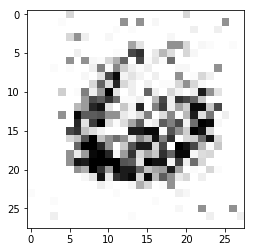

In [14]:
# create new pic
test_case_nu = 2
noise = np.random.uniform(size = (test_case_nu, image_size * image_size))
test_img = np.array(noise) * (2 ** bit_nu)
test_img = np.array(test_img, dtype = int)
test_set = []
for i in range(len(test_img)):
    for j in range(len(test_img[i,:])):
        test_set.append([int(x) for x in np.binary_repr(test_img[i,j], width = bit_nu)])

test_set = np.array(test_set)
test_set = test_set.reshape((len(noise), bit_nu * len(noise[0])))
test_set = torch.FloatTensor(test_set)
cwd = os.getcwd()
for i in range(test_case_nu):
    dir = os.path.join(cwd,"testset", str(i))
    if not os.path.exists(dir):
        os.mkdir(dir)
    
output = test_set
for j in range(10000):
    output = rbm.predict(output)
    if(j % 100 == 0):
        for i in range(test_case_nu):
            img = []
            for k in range(0, len(output[i]), bit_nu):
                element = 0.0
                for m in range(5):
                    element += (2 ** (bit_nu - 1 - m)) * output[i,k + m]
                img.append(element)
            img = np.array(img, dtype = float)
            img = img / (2 ** bit_nu)
            img = img.reshape(28, 28)
            # img = meanpooling(img)
            plt.imshow(img, cmap="Greys")
            directory = "./testset/" + str(i) + "/" + str(j) + ".png"
            plt.savefig(directory)
